In [ ]:
#IMPORT LIBRARIES
import os
from google.colab import drive
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from skimage.transform import rotate
from skimage.util import montage
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
!PYTHONHASHSEED=0

In [ ]:
# CONNECT TO DRIVE AND RETRIEVE RAW DATA
drive.mount('/content/gdrive')
train_images_path = "gdrive/MyDrive//DL_Project/imagesTr"
train_labels_path = "gdrive/MyDrive/DL_Project/labelsTr"

def get_nii_files(directory):
    nii_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                if not file.startswith('.'):  # Ignore hidden files
                    nii_files.append(os.path.join(root, file))
    return nii_files

train_image_files = get_nii_files(train_images_path)
train_label_files = get_nii_files(train_labels_path)

print(f"Found {len(train_image_files)} training images")
print(f"Found {len(train_label_files)} training labels")

Mounted at /content/gdrive
Found 484 training images
Found 484 training labels


In [ ]:
train_image_files[:10]
# Right Order

['gdrive/MyDrive//DL_Project/imagesTr/BRATS_001.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_002.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_003.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_004.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_005.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_006.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_007.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_008.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_009.nii.gz',
 'gdrive/MyDrive//DL_Project/imagesTr/BRATS_010.nii.gz']

In [ ]:
train_label_files[:10]
# Wrong order

['gdrive/MyDrive/DL_Project/labelsTr/BRATS_001.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_004.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_003.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_002.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_007.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_005.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_006.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_009.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_010.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_008.nii.gz']

In [ ]:
import re

# Extract number from file name -> use to order labels
def extract_number(file_name):
    match = re.search(r'BRATS_(\d+)', file_name)
    if match:
        return int(match.group(1))
    return -1

train_label_files = sorted(train_label_files, key=extract_number)
train_label_files[:10]


['gdrive/MyDrive/DL_Project/labelsTr/BRATS_001.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_002.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_003.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_004.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_005.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_006.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_007.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_008.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_009.nii.gz',
 'gdrive/MyDrive/DL_Project/labelsTr/BRATS_010.nii.gz']

In [ ]:
# Function to load scan of one subject
def load_nii_file(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

image = load_nii_file(train_image_files[54])
label = load_nii_file(train_label_files[54])
print( type(image), image.shape, type(label), label.shape)

<class 'numpy.ndarray'> (240, 240, 155, 4) <class 'numpy.ndarray'> (240, 240, 155)


## DATA EXPLORATION

In [ ]:
# Interactive function to show data
def interactive_slices(image, label, axis=2):
    modalities = ["T1", "T1gd", "T2", "FLAIR"]
    num_modalities = image.shape[3]  # MRI Modalities are last dimension

    if num_modalities != len(modalities):
        raise ValueError("Number of modalities does not match the expected number (4).")

    def view_slice(slice_index):
        fig, axes = plt.subplots(1, num_modalities + 1, figsize=(15, 5))

        if axis == 0:
            for i in range(num_modalities):
                axes[i].imshow(image[slice_index, :, :, i].T, cmap='gray', origin='lower')
                axes[i].set_title(modalities[i])
            axes[-1].imshow(label[slice_index, :, :].T, cmap='gray', origin='lower')
            axes[-1].set_title('Label')
        elif axis == 1:
            for i in range(num_modalities):
                axes[i].imshow(image[:, slice_index, :, i].T, cmap='gray', origin='lower')
                axes[i].set_title(modalities[i])
            axes[-1].imshow(label[:, slice_index, :].T, cmap='gray', origin='lower')
            axes[-1].set_title('Label')
        elif axis == 2:
            for i in range(num_modalities):
                axes[i].imshow(image[:, :, slice_index, i].T, cmap='gray', origin='lower')
                axes[i].set_title(modalities[i])
            axes[-1].imshow(label[:, :, slice_index].T, cmap='gray', origin='lower')
            axes[-1].set_title('Label')
        else:
            raise ValueError("Axis must be 0, 1, or 2.")

        plt.show()

    max_index = image.shape[axis] - 1
    interact = widgets.IntSlider(min=0, max=max_index, step=1, description='Slice Index')
    ui = widgets.HBox([interact])
    out = widgets.interactive_output(view_slice, {'slice_index': interact})
    display(ui, out)

# Use function
interactive_slices(image, label, axis=2)

Output()

In [ ]:
interactive_slices(image, label, axis=0)

Output()

In [ ]:
interactive_slices(image, label, axis=1)

Output()

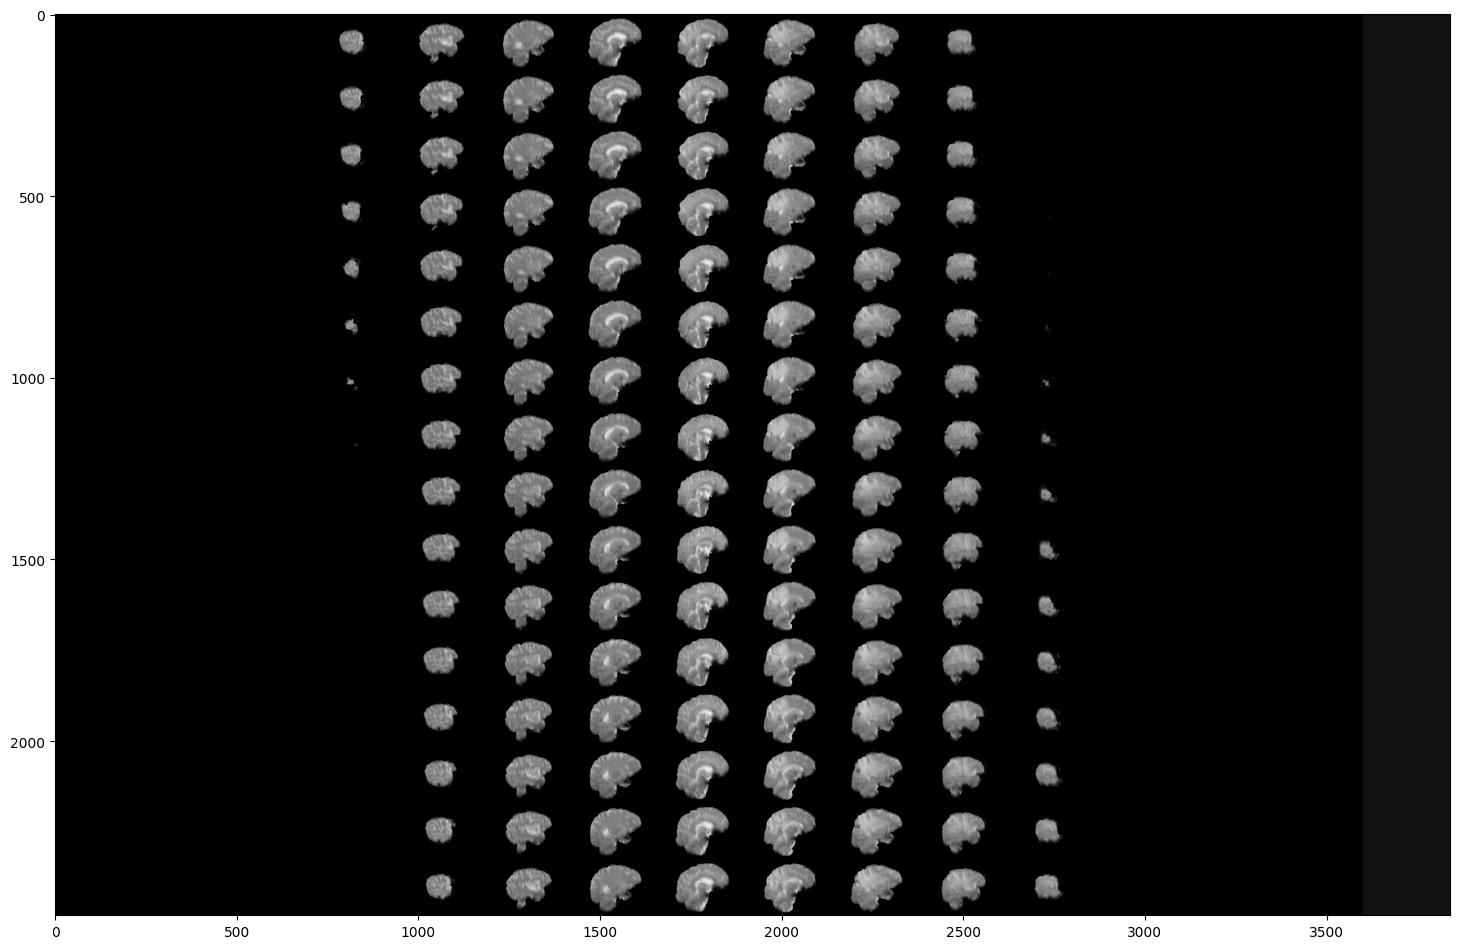

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (18,18))
ax1.imshow(rotate(montage(image[:,:,:, 3]), 90, resize=True), cmap ='gray')

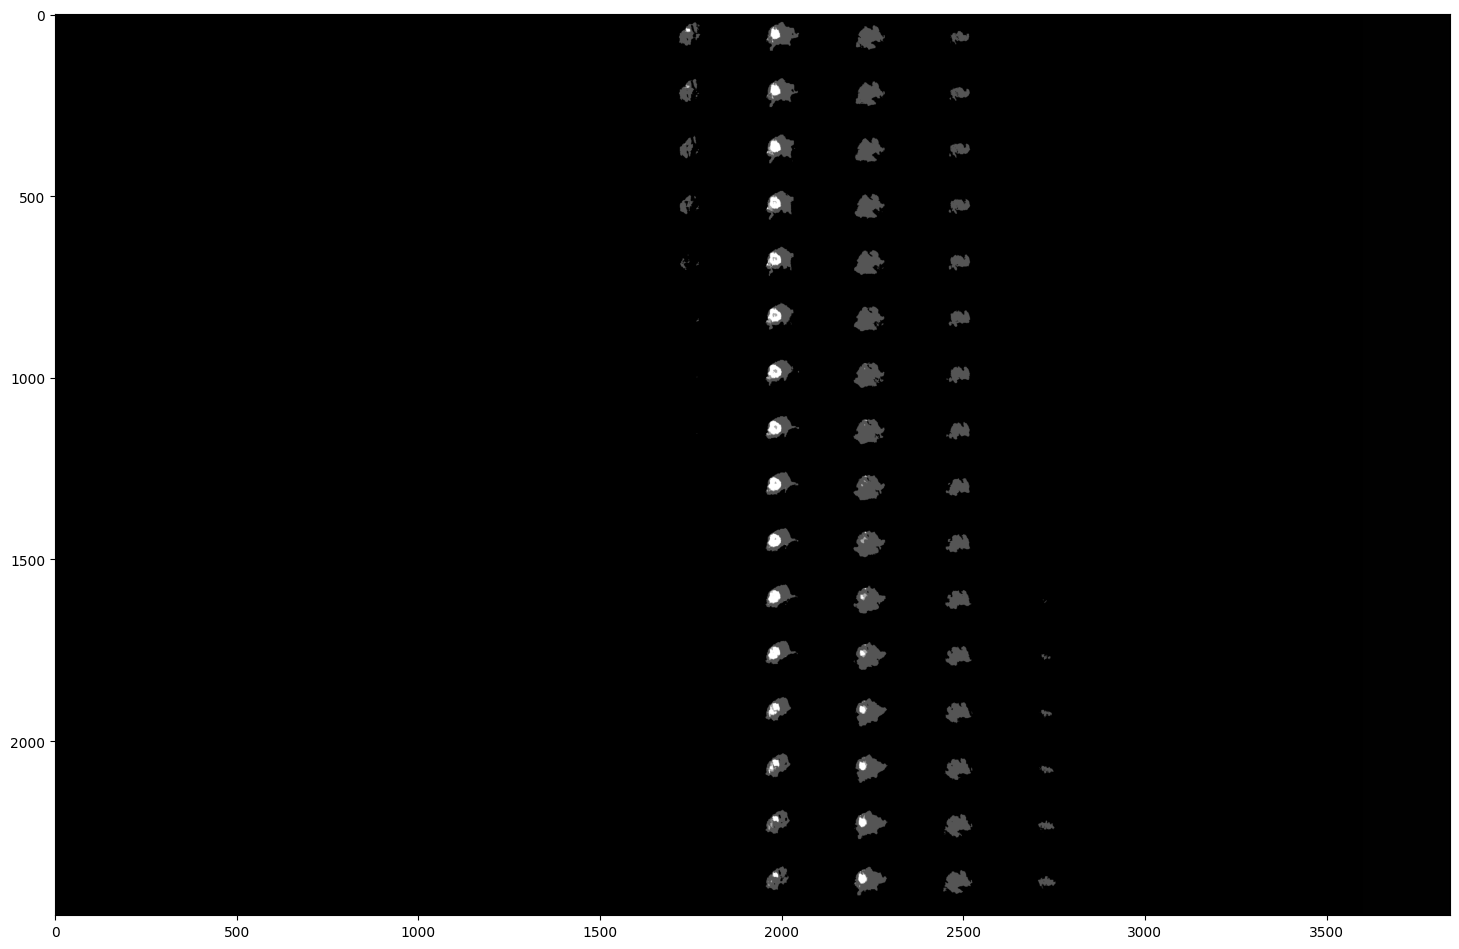

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (18,18))
ax1.imshow(rotate(montage(label[:,:,:]), 90, resize=True), cmap ='gray')

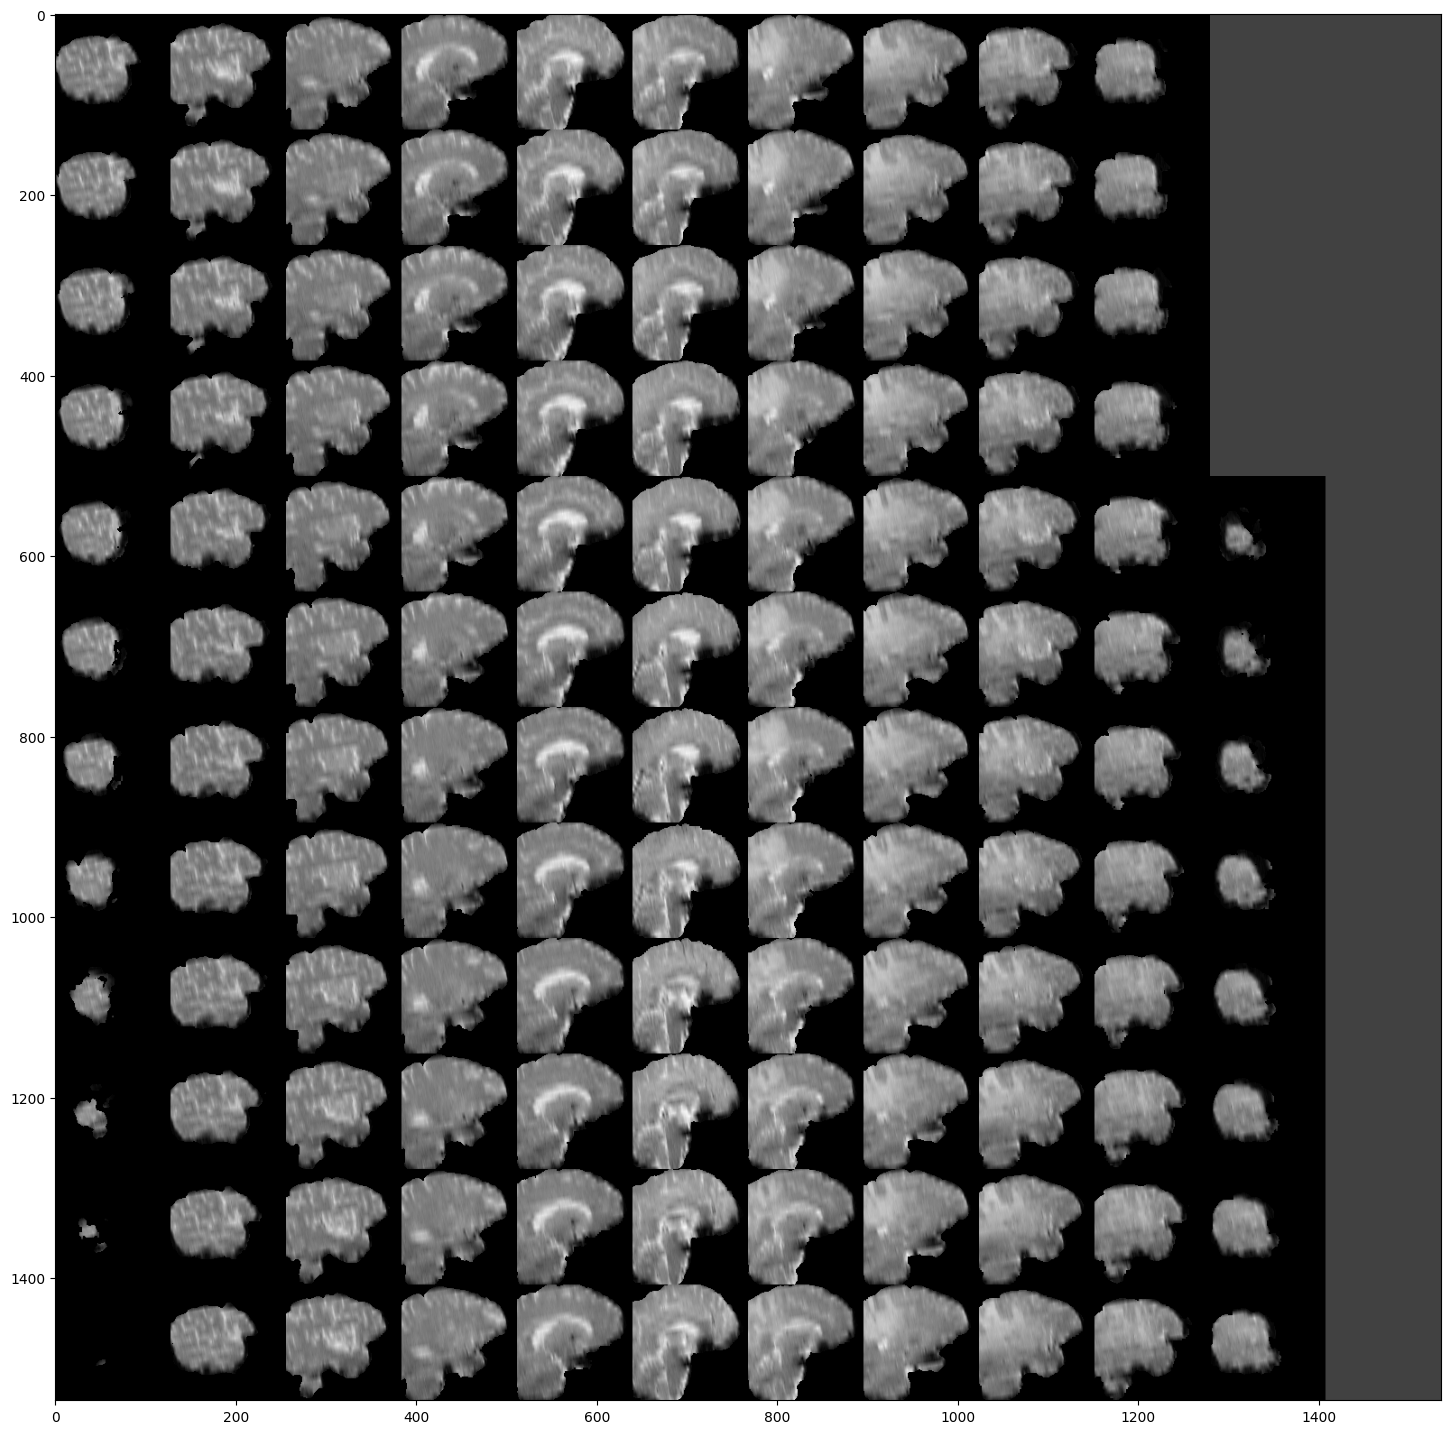

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (18,18))
ax1.imshow(rotate(montage(image[56:184, 56:184, 13:141, 3]), 90, resize=True), cmap ='gray')

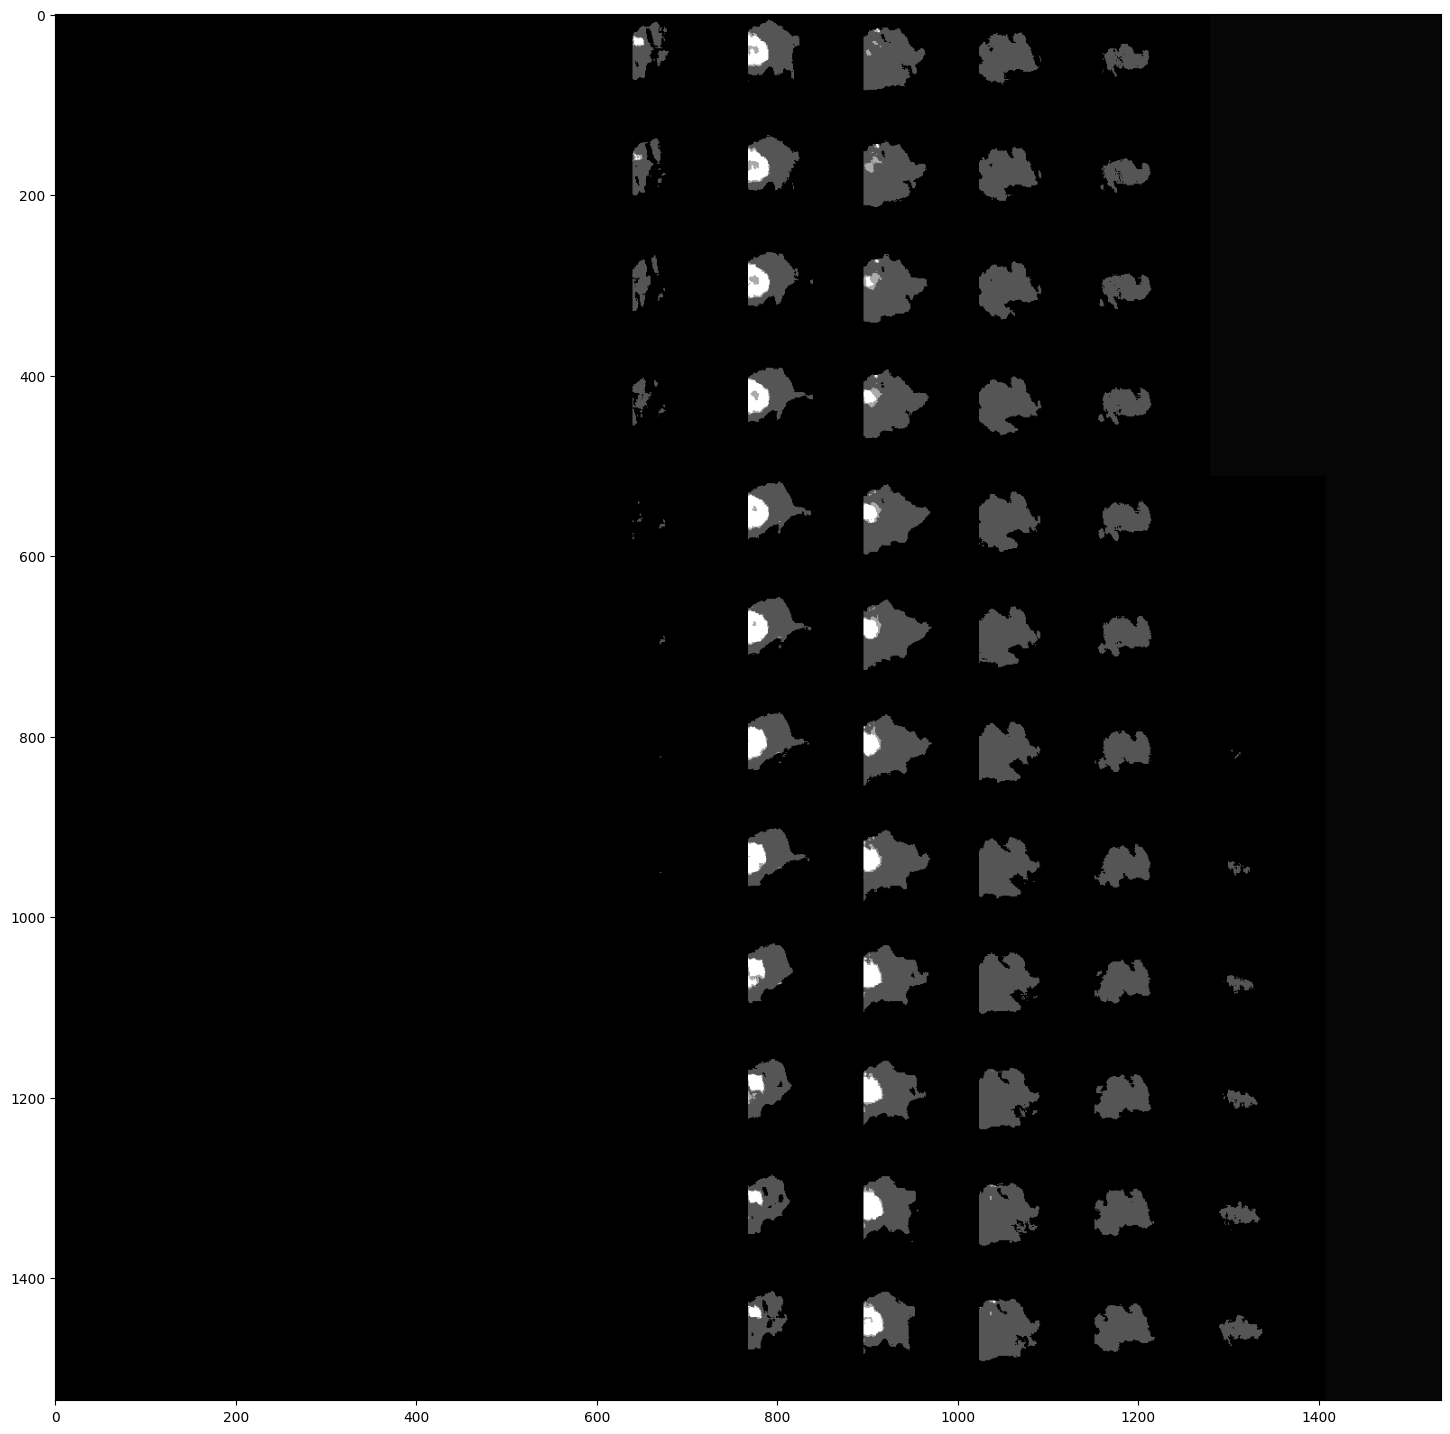

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (18,18))
ax1.imshow(rotate(montage(label[56:184, 56:184, 13:141]), 90, resize=True), cmap ='gray')

In [ ]:
def count_zero_slices_and_nonzero_voxels(label_data):
    zero_slices_x = np.sum(np.all(label_data == 0, axis=(1, 2)))
    zero_slices_y = np.sum(np.all(label_data == 0, axis=(0, 2)))
    zero_slices_z = np.sum(np.all(label_data == 0, axis=(0, 1)))
    nonzero_voxels = np.sum(label_data != 0)
    return zero_slices_x, zero_slices_y, zero_slices_z, nonzero_voxels

# Original volume
zero_slices_count_x, zero_slices_count_y, zero_slices_count_z, nonzero_voxels_count = count_zero_slices_and_nonzero_voxels(label)
print(f"Number of slices with all labels equal to zero along x-axis: {zero_slices_count_x}, p =", round(zero_slices_count_x/240, 3))
print(f"Number of slices with all labels equal to zero along y-axis: {zero_slices_count_y}, p =", round(zero_slices_count_y/240, 3))
print(f"Number of slices with all labels equal to zero along z-axis: {zero_slices_count_z}, p =", round(zero_slices_count_z/155, 3))
print(f"Total number of non-zero voxels: {nonzero_voxels_count}, p =", round(nonzero_voxels_count / (240*240*155), 3), "\n")

# Sampled volume
sub_label = label[56:184, 56:184, 13:141]  # 128X128X128 Subsample
zero_slices_count_x, zero_slices_count_y, zero_slices_count_z, nonzero_voxels_count = count_zero_slices_and_nonzero_voxels(sub_label)
print(f"Number of slices with all labels equal to zero along x-axis: {zero_slices_count_x}, p =", round(zero_slices_count_x/128, 3))
print(f"Number of slices with all labels equal to zero along y-axis: {zero_slices_count_y}, p =", round(zero_slices_count_y/128, 3))
print(f"Number of slices with all labels equal to zero along z-axis: {zero_slices_count_z}, p =", round(zero_slices_count_z/128, 3))
print(f"Total number of non-zero voxels: {nonzero_voxels_count}, p =", round(nonzero_voxels_count / (128*128*128), 3))


Number of slices with all labels equal to zero along x-axis: 178, p = 0.742
Number of slices with all labels equal to zero along y-axis: 144, p = 0.6
Number of slices with all labels equal to zero along z-axis: 74, p = 0.477
Total number of non-zero voxels: 148062, p = 0.017 

Number of slices with all labels equal to zero along x-axis: 66, p = 0.516
Number of slices with all labels equal to zero along y-axis: 52, p = 0.406
Number of slices with all labels equal to zero along z-axis: 47, p = 0.367
Total number of non-zero voxels: 127223, p = 0.061


# FILE MANAGEMENT AND DATA PREPROCESSING

In [ ]:
#Create path to save preprocessed data
x_train_path = "DL_project/data/128/X_train"
y_train_path = "DL_project/data/128/Y_train"

x_val_path = "DL_project/data/128/X_val"
y_val_path = "DL_project/data/128/Y_val"

x_test_path = "DL_project/data/X_test"
y_test_path = "DL_project/data/Y_test"

os.makedirs(x_train_path, exist_ok=True)
os.makedirs(y_train_path, exist_ok=True)
os.makedirs(x_val_path, exist_ok=True)
os.makedirs(y_val_path, exist_ok=True)
os.makedirs(x_test_path, exist_ok=True)
os.makedirs(y_test_path, exist_ok=True)

In [ ]:
# Split into training, validation and test sets
X_train, X_test, Y_train, Y_test = train_test_split(train_image_files, train_label_files, test_size = 0.3, random_state = 42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

# Optional: Save these arrays of file to disk for later use
data_path = "gdrive/MyDrive/DL_Project/data"
np.save(os.path.join(data_path, 'train_images.npy'), X_train)
np.save(os.path.join(data_path, 'train_labels.npy'), Y_train)
np.save(os.path.join(data_path, 'validation_images.npy'), X_val)
np.save(os.path.join(data_path, 'validation_labels.npy'), Y_val)
np.save(os.path.join(data_path, 'test_images.npy'), X_test)
np.save(os.path.join(data_path, 'test_labels.npy'), Y_test)

In [ ]:
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))
print(len(X_test), len(Y_test))

338 338
73 73
73 73


In [ ]:
#Define function to normalize data separately for each MRI channel
def normalize_per_channel(img):
    #Initialize an array of the same shape of img in order to save normalized data
    scaled_img = np.zeros_like(img)
    scaler = MinMaxScaler()

    for i in range(img.shape[-1]):
        # Remodel channel to adapt to MinMaxScaler
        reshaped_channel = img[..., i].reshape(-1, 1)
        # Apply MinMaxScaler
        scaled_channel = scaler.fit_transform(reshaped_channel)
        # Back to the original shape
        scaled_img[..., i] = scaled_channel.reshape(img[..., i].shape)

    return scaled_img

In [ ]:
###
for idx, img_path in enumerate(X_train):
    # load image and label
    img = load_nii_file(X_train[idx])
    label = load_nii_file(Y_train[idx])

    # Normalize
    img = normalize_per_channel(img)

    # Cut Out images and label --> keep 128x128x128 central volume
    img = img[56:184, 56:184, 13:141, :]
    label = label[56:184, 56:184, 13:141]

    # One Hot Encode class label
    label = label.astype(np.uint8)
    label = to_categorical(label, num_classes=4)

    # Extract file's name
    base_filename = os.path.basename(img_path)
    short_filename = base_filename.split('BRATS_')[1].split('.nii.gz')[0]
    # Stampa di debug per verificare i nomi dei file
    print(f"Saving image_{short_filename}.npy and label_{short_filename}.npy")

    # Save preprocessed data
    np.save(os.path.join(x_train_path, f'image_{short_filename}.npy'), img)
    np.save(os.path.join(y_train_path, f'label_{short_filename}.npy'), label)

Saving image_204.npy and label_204.npy
Saving image_311.npy and label_311.npy
Saving image_061.npy and label_061.npy
Saving image_111.npy and label_111.npy
Saving image_405.npy and label_405.npy
Saving image_406.npy and label_406.npy
Saving image_030.npy and label_030.npy
Saving image_173.npy and label_173.npy
Saving image_156.npy and label_156.npy
Saving image_027.npy and label_027.npy
Saving image_008.npy and label_008.npy
Saving image_441.npy and label_441.npy
Saving image_109.npy and label_109.npy
Saving image_038.npy and label_038.npy
Saving image_158.npy and label_158.npy
Saving image_452.npy and label_452.npy
Saving image_119.npy and label_119.npy
Saving image_115.npy and label_115.npy
Saving image_442.npy and label_442.npy
Saving image_315.npy and label_315.npy
Saving image_145.npy and label_145.npy
Saving image_359.npy and label_359.npy
Saving image_369.npy and label_369.npy
Saving image_183.npy and label_183.npy
Saving image_254.npy and label_254.npy
Saving image_263.npy and 

In [ ]:
###
for idx, img_path in enumerate(X_val):
    # Load image and label
    img = load_nii_file(X_val[idx])
    label = load_nii_file(Y_val[idx])

    # Normalize
    img = normalize_per_channel(img)

    # Cut out volume
    img = img[56:184, 56:184, 13:141, :]
    label = label[56:184, 56:184, 13:141]

    # OHE
    label = label.astype(np.uint8)
    label = to_categorical(label, num_classes=4)

    # Extract file's name
    base_filename = os.path.basename(img_path)
    short_filename = base_filename.split('BRATS_')[1].split('.nii.gz')[0]


    print(f"Saving image_{short_filename}.npy and label_{short_filename}.npy")

    # Save preprocessed data
    np.save(os.path.join(x_val_path, f'image_{short_filename}.npy'), img)
    np.save(os.path.join(y_val_path, f'label_{short_filename}.npy'), label)

Saving image_251.npy and label_251.npy
Saving image_149.npy and label_149.npy
Saving image_067.npy and label_067.npy
Saving image_322.npy and label_322.npy
Saving image_040.npy and label_040.npy
Saving image_012.npy and label_012.npy
Saving image_196.npy and label_196.npy
Saving image_001.npy and label_001.npy
Saving image_312.npy and label_312.npy
Saving image_387.npy and label_387.npy
Saving image_463.npy and label_463.npy
Saving image_267.npy and label_267.npy
Saving image_347.npy and label_347.npy
Saving image_076.npy and label_076.npy
Saving image_018.npy and label_018.npy
Saving image_421.npy and label_421.npy
Saving image_453.npy and label_453.npy
Saving image_480.npy and label_480.npy
Saving image_324.npy and label_324.npy
Saving image_427.npy and label_427.npy
Saving image_273.npy and label_273.npy
Saving image_447.npy and label_447.npy
Saving image_031.npy and label_031.npy
Saving image_361.npy and label_361.npy
Saving image_077.npy and label_077.npy
Saving image_133.npy and 

In [ ]:
import shutil
# Path to folder containing preprocessed data
base_path = '/content/DL_project/data/128'
# Path to save zip file
output_zip = '/content/128.zip'
# Comprime folder 128
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', base_path)
print(f'Completata la compressione di {base_path} in {output_zip}')

Completata la compressione di /content/DL_project/data/128 in /content/128.zip


In [ ]:
drive.mount('/content/gdrive')
# Google drive path
drive_dest_path = '/content/gdrive/MyDrive/DL_Project/data'
# Upload zip file on drive
shutil.copy(output_zip, drive_dest_path)
print(f'Caricato il file {output_zip} su {drive_dest_path}')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Caricato il file /content/128.zip su /content/gdrive/MyDrive/DL_Project/data
